# XOR

The inputs are all possible pairs of binary values:
- (0, 0)
- (0, 1)
- (1, 0)
- (1, 1)


The outputs follow the XOR truth table:
1. Output is 1 only when the inputs are different
2. Output is 0 when the inputs are the same

## Why XOR is important
**XOR is not linearly separable.**

You cannot draw a single straight line that separates the 1s from the 0s.
A single‑layer perceptron cannot solve XOR.

You need:
A hidden layer
A nonlinear activation function
This is the smallest example that proves why neural networks must be nonlinear.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# xor dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

## What these shapes mean

1. hidden_weights: shape (2, 2)
 - Maps 2 inputs → 2 hidden neurons
2. hidden_biases: shape (2)
 - One bias per hidden neuron
3. output_weights: shape (2)
 - Takes the 2 hidden activations → 1 output neuron
4. output_bias: scalar
 - Bias for the output neuron
 
Random initialization ensures each neuron starts differently so they can learn different features.


In [2]:
#Initializing the Network Parameters

np.random.seed(42)
hidden_weights = np.random.randn(2, 2)
hidden_biases = np.random.randn(2)
output_weights = np.random.randn(2)
output_bias = np.random.randn()


In [3]:
# Activation Function
sigmoid = lambda z: 1 / (1 + np.exp(-z))
sigmoid_deriv = lambda y: y * (1 - y)


#Sigmoid squashes values into the range (0, 1).
# Its derivative is simple and works well for small networks.

## Hyperparameters and Traces

- lr: learning rate
- epochs: number of full passes through the dataset
- loss_history: track training progress
- weight_trace: track how output weights change
- prediction_trace: store predictions over time
- hidden_activation_trace: store hidden neuron activations
- interval: record snapshots every 100 epochs

These traces help visualize how the network learns XOR.


In [4]:
lr = 0.1
epochs = 10000
loss_history = []
weight_trace = []
prediction_trace = defaultdict(list)
hidden_activation_trace = defaultdict(list)
interval = 100

In [5]:
for epoch in range(epochs):
    total_loss = 0

    for i in range(4):
        x_sample = X[i]
        target_val = y[i]

        # Forward pass: Hidden layer
        z_hidden = hidden_weights @ x_sample + hidden_biases
        hidden_outputs = sigmoid(z_hidden)

        # Forward pass: Output layer
        z_output = output_weights @ hidden_outputs + output_bias
        y_hat = sigmoid(z_output)

        # Loss
        loss = 0.5 * (y_hat - target_val) ** 2
        total_loss += loss

        # Backprop: Output layer
        dL_dyhat = y_hat - target_val
        dyhat_dz = sigmoid_deriv(y_hat)
        dL_dz_output = dL_dyhat * dyhat_dz

        dL_dw_output = dL_dz_output * hidden_outputs
        dL_db_output = dL_dz_output

        # Backprop: Hidden layer
        d_hidden = sigmoid_deriv(hidden_outputs)
        dL_dz_hidden = output_weights * dL_dz_output * d_hidden
        dL_dw_hidden = np.outer(dL_dz_hidden, x_sample)
        dL_db_hidden = dL_dz_hidden

        # Gradient descent update
        output_weights -= lr * dL_dw_output
        output_bias -= lr * dL_db_output
        hidden_weights -= lr * dL_dw_hidden
        hidden_biases -= lr * dL_db_hidden

        weight_trace.append(output_weights.copy())

    # End of epoch
    loss_history.append(total_loss / 4)

    if epoch % interval == 0:
        for i in range(4):
            x_sample = X[i]
            z_hidden = hidden_weights @ x_sample + hidden_biases
            hidden_outputs = sigmoid(z_hidden)
            z_output = output_weights @ hidden_outputs + output_bias
            y_pred = sigmoid(z_output)
            prediction_trace[i].append(y_pred)
            hidden_activation_trace[i].append(hidden_outputs.copy())


## Training Loop and Forward Pass

What’s happening here? 

1. Multiply inputs by hidden weights
2. Add hidden biases
3. Apply sigmoid

4. Multiply hidden activations by output weights
5. Add output bias
6. Apply sigmoid again

This produces the network’s prediction **y_hat.**


In [6]:
'''
for epoch in range(epochs):
    total_loss = 0
    for i in range(4):
        x_sample = X[i]
        target_val = y[i]


        # Forward pass: Hidden layer
        z_hidden = hidden_weights @ x_sample + hidden_biases
        hidden_outputs = sigmoid(z_hidden)


        # Forward pass: Output layer
        z_output = output_weights @ hidden_outputs + output_bias
        y_hat = sigmoid(z_output)
'''

'\nfor epoch in range(epochs):\n    total_loss = 0\n    for i in range(4):\n        x_sample = X[i]\n        target_val = y[i]\n\n\n        # Forward pass: Hidden layer\n        z_hidden = hidden_weights @ x_sample + hidden_biases\n        hidden_outputs = sigmoid(z_hidden)\n\n\n        # Forward pass: Output layer\n        z_output = output_weights @ hidden_outputs + output_bias\n        y_hat = sigmoid(z_output)\n'

In [7]:
''' Loss Function (Mean Squared Error)
loss = 0.5 * (y_hat - target_val) ** 2
total_loss += loss


#We use MSE for simplicity.'''


' Loss Function (Mean Squared Error)\nloss = 0.5 * (y_hat - target_val) ** 2\ntotal_loss += loss\n\n\n#We use MSE for simplicity.'

## Backpropagation: Output Layer

This computes:
- How much the output changed the loss
- How much the output weights contributed
- How much the output bias contributed


In [8]:
'''
dL_dyhat = y_hat - target_val
dyhat_dz = sigmoid_deriv(y_hat)
dL_dz_output = dL_dyhat * dyhat_dz


dL_dw_output = dL_dz_output * hidden_outputs
dL_db_output = dL_dz_output
'''

'\ndL_dyhat = y_hat - target_val\ndyhat_dz = sigmoid_deriv(y_hat)\ndL_dz_output = dL_dyhat * dyhat_dz\n\n\ndL_dw_output = dL_dz_output * hidden_outputs\ndL_db_output = dL_dz_output\n'

## Backpropagation: Hidden Layer

- This applies the chain rule:
- The output error flows backward through the output weights
- Each hidden neuron receives part of that error
- Multiply by the derivative of the hidden activation
- Compute gradients for hidden weights and biases

This is the core of backpropagation.


In [9]:
'''
d_hidden = sigmoid_deriv(hidden_outputs)
dL_dz_hidden = output_weights * dL_dz_output * d_hidden
dL_dw_hidden = np.outer(dL_dz_hidden, x_sample)
dL_db_hidden = dL_dz_hidden
'''

'\nd_hidden = sigmoid_deriv(hidden_outputs)\ndL_dz_hidden = output_weights * dL_dz_output * d_hidden\ndL_dw_hidden = np.outer(dL_dz_hidden, x_sample)\ndL_db_hidden = dL_dz_hidden\n'

In [10]:
'''
#Gradient Descent Updates

output_weights -= lr * dL_dw_output
output_bias -= lr * dL_db_output
hidden_weights -= lr * dL_dw_hidden
hidden_biases -= lr * dL_db_hidden


weight_trace.append(output_weights.copy())


#Each parameter moves a small step in the direction that reduces the loss.
'''


'\n#Gradient Descent Updates\n\noutput_weights -= lr * dL_dw_output\noutput_bias -= lr * dL_db_output\nhidden_weights -= lr * dL_dw_hidden\nhidden_biases -= lr * dL_db_hidden\n\n\nweight_trace.append(output_weights.copy())\n\n\n#Each parameter moves a small step in the direction that reduces the loss.\n'

In [11]:
'''
#Epoch Loss and Periodic Evaluation

loss_history.append(total_loss / 4)


if epoch % interval == 0:
    for i in range(4):
        x_sample = X[i]
        z_hidden = hidden_weights @ x_sample + hidden_biases
        hidden_outputs = sigmoid(z_hidden)
        z_output = output_weights @ hidden_outputs + output_bias
        y_pred = sigmoid(z_output)
        prediction_trace[i].append(y_pred)
        hidden_activation_trace[i].append(hidden_outputs.copy())


This records:
Loss over time
Predictions for each XOR input
Hidden neuron activations
These traces reveal how the network learns nonlinear features.'''


'\n#Epoch Loss and Periodic Evaluation\n\nloss_history.append(total_loss / 4)\n\n\nif epoch % interval == 0:\n    for i in range(4):\n        x_sample = X[i]\n        z_hidden = hidden_weights @ x_sample + hidden_biases\n        hidden_outputs = sigmoid(z_hidden)\n        z_output = output_weights @ hidden_outputs + output_bias\n        y_pred = sigmoid(z_output)\n        prediction_trace[i].append(y_pred)\n        hidden_activation_trace[i].append(hidden_outputs.copy())\n\n\nThis records:\nLoss over time\nPredictions for each XOR input\nHidden neuron activations\nThese traces reveal how the network learns nonlinear features.'

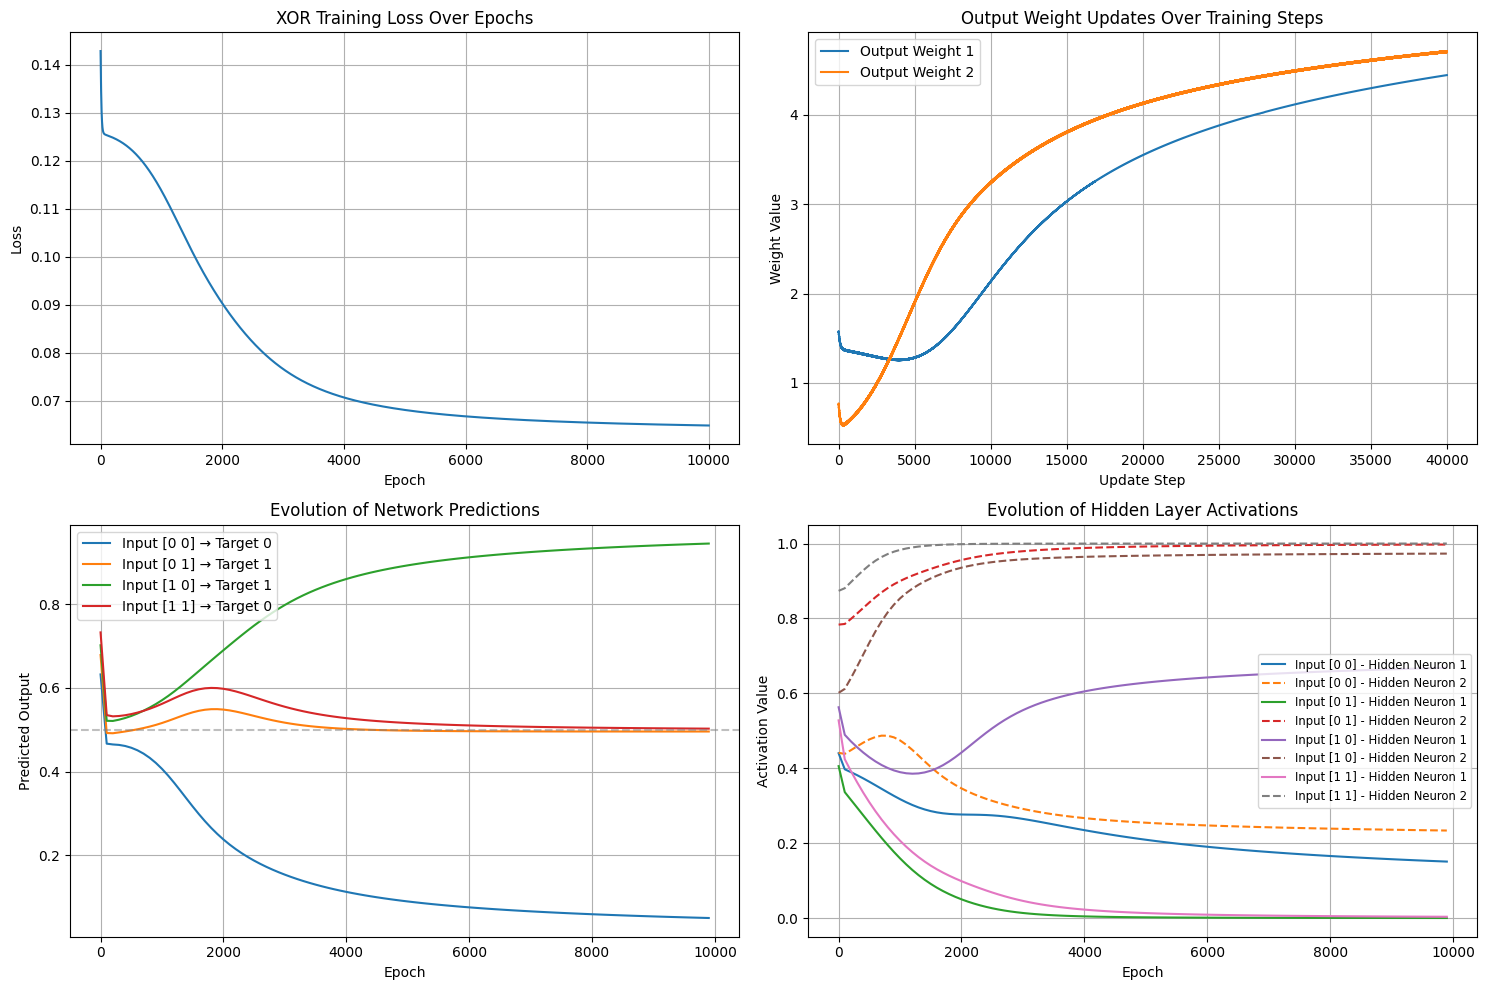

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))


# Plot 1: Loss Curve
axs[0, 0].plot(loss_history)
axs[0, 0].set_title("XOR Training Loss Over Epochs")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)


# Plot 2: Output Weight Updates
weight_trace_arr = np.array(weight_trace)
axs[0, 1].plot(weight_trace_arr[:, 0], label='Output Weight 1')
axs[0, 1].plot(weight_trace_arr[:, 1], label='Output Weight 2')
axs[0, 1].legend()
axs[0, 1].set_title("Output Weight Updates Over Training Steps")
axs[0, 1].set_xlabel("Update Step")
axs[0, 1].set_ylabel("Weight Value")
axs[0, 1].grid(True)


# Plot 3: Prediction Evolution
epochs_recorded = np.arange(0, epochs, interval)
for i in range(4):
    axs[1, 0].plot(epochs_recorded, prediction_trace[i],
                   label=f"Input {X[i]} → Target {y[i]}")
axs[1, 0].axhline(0.5, linestyle='--', color='gray', alpha=0.5)
axs[1, 0].set_title("Evolution of Network Predictions")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Predicted Output")
axs[1, 0].legend()
axs[1, 0].grid(True)


# Plot 4: Hidden Layer Activations
for i in range(4):
    activations = np.array(hidden_activation_trace[i])
    axs[1, 1].plot(epochs_recorded, activations[:, 0],
                   label=f"Input {X[i]} - Hidden Neuron 1")
    axs[1, 1].plot(epochs_recorded, activations[:, 1],
                   label=f"Input {X[i]} - Hidden Neuron 2", linestyle='--')
axs[1, 1].set_title("Evolution of Hidden Layer Activations")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Activation Value")
axs[1, 1].legend(fontsize='small')
axs[1, 1].grid(True)


plt.tight_layout()
plt.show()


## What these plots show

- Loss curve: Should steadily decrease
- Output weights: Show how the network adjusts its final decision boundary
- Predictions: Each XOR input gradually moves toward its correct output
- Hidden activations:
    - One neuron typically learns something like “OR-ish”
    - The other learns something like “AND-ish not”
    - Together they form a nonlinear representation that solves XOR
